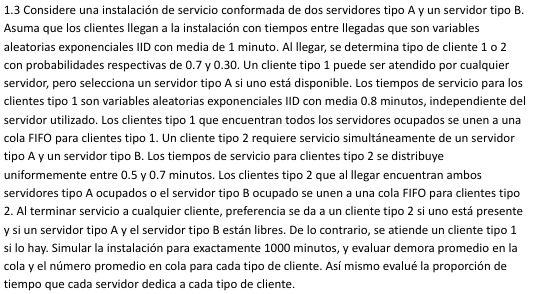

## Código implementación modelo ejercicio 1.3

In [ ]:
# Simulación de sistema de atención con servidores tipo A y B
import random
import heapq

# Semilla para reproducibilidad
random.seed(44)

# Parámetros del sistema
TIEMPO_SIMULACION = 1000  # minutos
MEDIA_LLEGADAS = 1.0
MEDIA_SERVICIO_TIPO1 = 0.8
UNIFORME_MIN_TIPO2 = 0.5
UNIFORME_MAX_TIPO2 = 0.7

# Variables de estado
tiempo_actual = 0
eventos = []

# Estado de servidores
servidores_A = {'A1': None, 'A2': None}
servidor_B = None

# Colas
cola_tipo1 = []
cola_tipo2 = []

# Estadísticas
total_espera_tipo1 = 0
clientes_atendidos_tipo1 = 0
area_bajo_cola_tipo1 = 0
tiempo_ultimo_evento_tipo1 = 0

total_espera_tipo2 = 0
clientes_atendidos_tipo2 = 0
area_bajo_cola_tipo2 = 0
tiempo_ultimo_evento_tipo2 = 0

uso_servidores = {
    'A1': {'tipo1': 0.0, 'tipo2': 0.0},
    'A2': {'tipo1': 0.0, 'tipo2': 0.0},
    'B': {'tipo2': 0.0}
}

# Funciones auxiliares
def generar_tiempo_exponencial(media):
    return random.expovariate(1 / media)

def generar_tiempo_uniforme(a, b):
    return random.uniform(a, b)

def agendar_evento(tiempo, tipo_evento, datos=None):
    heapq.heappush(eventos, (tiempo, tipo_evento, datos))

def asignar_cliente_tipo1(tiempo_llegada):
    global tiempo_actual, clientes_atendidos_tipo1, total_espera_tipo1
    for nombre, ocupado in servidores_A.items():
        if ocupado is None:
            tiempo_servicio = generar_tiempo_exponencial(MEDIA_SERVICIO_TIPO1)
            servidores_A[nombre] = ('tipo1', tiempo_actual + tiempo_servicio)
            total_espera_tipo1 += tiempo_actual - tiempo_llegada
            clientes_atendidos_tipo1 += 1
            agendar_evento(tiempo_actual + tiempo_servicio, 'fin_servicio', {'servidor': nombre})
            uso_servidores[nombre]['tipo1'] += tiempo_servicio
            return True
    return False

def asignar_cliente_tipo2(tiempo_llegada):
    global tiempo_actual, clientes_atendidos_tipo2, total_espera_tipo2, servidor_B
    if servidor_B is None:
        for nombre, ocupado in servidores_A.items():
            if ocupado is None:
                tiempo_servicio = generar_tiempo_uniforme(UNIFORME_MIN_TIPO2, UNIFORME_MAX_TIPO2)
                servidores_A[nombre] = ('tipo2', tiempo_actual + tiempo_servicio)
                servidor_B = ('tipo2', tiempo_actual + tiempo_servicio)
                total_espera_tipo2 += tiempo_actual - tiempo_llegada
                clientes_atendidos_tipo2 += 1
                agendar_evento(tiempo_actual + tiempo_servicio, 'fin_servicio', {'servidor': nombre, 'servidorB': True})
                uso_servidores[nombre]['tipo2'] += tiempo_servicio
                uso_servidores['B']['tipo2'] += tiempo_servicio
                return True
    return False

# Inicializar primer evento
agendar_evento(tiempo_actual + generar_tiempo_exponencial(MEDIA_LLEGADAS), 'llegada')

# Procesador de eventos
while eventos and tiempo_actual < TIEMPO_SIMULACION:
    tiempo_evento, tipo_evento, datos = heapq.heappop(eventos)
    tiempo_actual = tiempo_evento

    area_bajo_cola_tipo1 += len(cola_tipo1) * (tiempo_actual - tiempo_ultimo_evento_tipo1)
    area_bajo_cola_tipo2 += len(cola_tipo2) * (tiempo_actual - tiempo_ultimo_evento_tipo2)
    tiempo_ultimo_evento_tipo1 = tiempo_actual
    tiempo_ultimo_evento_tipo2 = tiempo_actual

    if tipo_evento == 'llegada':
        tipo_cliente = 'tipo1' if random.random() < 0.7 else 'tipo2'
        if tipo_cliente == 'tipo1':
            if not asignar_cliente_tipo1(tiempo_actual):
                cola_tipo1.append(tiempo_actual)
        else:
            if not asignar_cliente_tipo2(tiempo_actual):
                cola_tipo2.append(tiempo_actual)
        agendar_evento(tiempo_actual + generar_tiempo_exponencial(MEDIA_LLEGADAS), 'llegada')

    elif tipo_evento == 'fin_servicio':
        servidor = datos['servidor']
        if datos.get('servidorB', False):
            servidor_B = None
        servidores_A[servidor] = None

        atendido = False
        if cola_tipo2 and servidor_B is None:
            for nombre, ocupado in servidores_A.items():
                if ocupado is None:
                    llegada = cola_tipo2.pop(0)
                    asignar_cliente_tipo2(llegada)
                    atendido = True
                    break

        if not atendido and cola_tipo1:
            for nombre, ocupado in servidores_A.items():
                if ocupado is None:
                    llegada = cola_tipo1.pop(0)
                    asignar_cliente_tipo1(llegada)
                    break

# Métricas
tiempo_sim = min(tiempo_actual, TIEMPO_SIMULACION)
espera_prom_tipo1 = total_espera_tipo1 / clientes_atendidos_tipo1 if clientes_atendidos_tipo1 > 0 else 0
espera_prom_tipo2 = total_espera_tipo2 / clientes_atendidos_tipo2 if clientes_atendidos_tipo2 > 0 else 0
cola_prom_tipo1 = area_bajo_cola_tipo1 / tiempo_sim
cola_prom_tipo2 = area_bajo_cola_tipo2 / tiempo_sim
uso_relativo = {s: {t: uso / tiempo_sim for t, uso in usos.items()} for s, usos in uso_servidores.items()}

# Resultados
print(f"Tiempo de espera promedio tipo 1: {espera_prom_tipo1:.3f} minutos")
print(f"Tiempo de espera promedio tipo 2: {espera_prom_tipo2:.3f} minutos")
print(f"Número promedio en cola tipo 1: {cola_prom_tipo1:.3f}")
print(f"Número promedio en cola tipo 2: {cola_prom_tipo2:.3f}")
print("Uso relativo de servidores:")
for s, usos in uso_relativo.items():
    for t, uso in usos.items():
        print(f"  Servidor {s}, Cliente {t}: {uso:.3%}")



Tiempo de espera promedio tipo 1: 0.113 minutos
Tiempo de espera promedio tipo 2: 0.087 minutos
Número promedio en cola tipo 1: 0.083
Número promedio en cola tipo 2: 0.026
Uso relativo de servidores:
  Servidor A1, Cliente tipo1: 33.864%
  Servidor A1, Cliente tipo2: 13.311%
  Servidor A2, Cliente tipo1: 20.534%
  Servidor A2, Cliente tipo2: 5.130%
  Servidor B, Cliente tipo2: 18.441%


*1.4 Un teatro utiliza un empleado para vender tiquetes y responder consultas desde las 9 a. m hasta las 5 p. m. Los puestos se adjudican únicamente si el cliente llega al teatro y paga por los tiquetes. Consultas provienen de clientes en persona o de llamadas al teatro y El empleado da prioridad a los clientes en persona. Sin embargo, gracias a un sistema complejo telefónico, las llamadas pueden esperar para ser atendidos según la política FIFO (primero en llegar primero en salir) y no renuncian hasta obtener una respuesta. Los clientes en persona llegan según una distribución exponencial con media de 12 minutos y su tiempo de servicio se distribuye exponencial con media de 6 minutos. Las llamadas ocurren según una distribución exponencial con media de 10 minutos y su tiempo de servicio sigue una distribución exponencial con media de 5 minutos. La primera persona llega a los 2 minutos y la primera llamada a los 3 minutos. Simular este sistema para un día de 8 horas y obtenga el tiempo de espera promedio de cada tipo de cliente.*

## Código implementación modelo ejercicio 1.4

In [ ]:
import random
import math

# Variables globales para las medias de las distribuciones exponenciales (en minutos)
MEDIA_LLEGADA_PERSONA = 12
MEDIA_SERVICIO_PERSONA = 6
MEDIA_LLEGADA_LLAMADA = 10
MEDIA_SERVICIO_LLAMADA = 5
TIEMPO_TOTAL_SIMULACION = 8 * 60  # 8 horas en minutos

# Variables de estado del sistema
tiempo_actual = 0.0
cola_llamadas = []
cola_personas = []
empleado_ocupado = False
tipo_servicio_actual = None  # 'persona' o 'llamada'
tiempo_fin_servicio = 0.0

# Variables acumuladas e indicadores de desempeño
total_espera_persona = 0.0
clientes_atendidos_persona = 0
total_espera_llamada = 0.0
llamadas_atendidas = 0

# Tiempo del próximo evento
tiempo_proxima_llegada_persona = float('inf')
tiempo_proxima_llegada_llamada = float('inf')

def generar_tiempo_exponencial(media):
    """Genera un tiempo aleatorio a partir de una distribución exponencial."""
    return random.expovariate(1/media) if media > 0 else float('inf')

def iniciar_simulacion():
    """Inicializa el sistema y programa los primeros eventos de llegada."""
    global tiempo_actual, tiempo_proxima_llegada_persona, tiempo_proxima_llegada_llamada

    tiempo_actual = 0.0
    tiempo_proxima_llegada_persona = 2.0
    tiempo_proxima_llegada_llamada = 3.0

def llegada_cliente_persona():
    """Simula la llegada de un cliente en persona."""
    global tiempo_actual, tiempo_proxima_llegada_persona, empleado_ocupado, cola_personas

    tiempo_llegada = tiempo_actual
    tiempo_servicio = generar_tiempo_exponencial(MEDIA_SERVICIO_PERSONA)
    tiempo_proxima_llegada_persona = tiempo_actual + generar_tiempo_exponencial(MEDIA_LLEGADA_PERSONA)

    if not empleado_ocupado:
        atender_cliente_persona(tiempo_llegada, tiempo_servicio)
    else:
        cola_personas.append(tiempo_llegada)

def atender_cliente_persona(tiempo_llegada, tiempo_servicio):
    """Inicia el servicio para un cliente en persona."""
    global empleado_ocupado, tiempo_fin_servicio, clientes_atendidos_persona, tipo_servicio_actual, total_espera_persona

    empleado_ocupado = True
    tipo_servicio_actual = 'persona'
    tiempo_fin_servicio = tiempo_actual + tiempo_servicio
    clientes_atendidos_persona += 1
    if tiempo_llegada < tiempo_actual:
        total_espera_persona += (tiempo_actual - tiempo_llegada)

def llegada_llamada():
    """Simula la llegada de una llamada de un cliente."""
    global tiempo_actual, tiempo_proxima_llegada_llamada, cola_llamadas

    tiempo_llegada = tiempo_actual
    cola_llamadas.append(tiempo_llegada)
    tiempo_proxima_llegada_llamada = tiempo_actual + generar_tiempo_exponencial(MEDIA_LLEGADA_LLAMADA)

def atender_llamada():
    """Inicia el servicio para una llamada."""
    global tiempo_actual, empleado_ocupado, tiempo_fin_servicio, cola_llamadas, total_espera_llamada, llamadas_atendidas, tipo_servicio_actual

    if cola_llamadas:
        tiempo_llegada = cola_llamadas.pop(0)
        tiempo_servicio = generar_tiempo_exponencial(MEDIA_SERVICIO_LLAMADA)
        empleado_ocupado = True
        tipo_servicio_actual = 'llamada'
        tiempo_fin_servicio = tiempo_actual + tiempo_servicio
        tiempo_espera = tiempo_actual - tiempo_llegada
        total_espera_llamada += tiempo_espera
        llamadas_atendidas += 1

def finalizar_servicio():
    """Actualiza el estado del sistema al finalizar un servicio."""
    global empleado_ocupado, tipo_servicio_actual

    empleado_ocupado = False
    tipo_servicio_actual = None

def determinar_proximo_servicio():
    """Determina qué tipo de cliente atender a continuación según la prioridad."""
    if cola_personas:
        tiempo_llegada = cola_personas.pop(0)
        tiempo_servicio = generar_tiempo_exponencial(MEDIA_SERVICIO_PERSONA)
        atender_cliente_persona(tiempo_llegada, tiempo_servicio)
    elif cola_llamadas:
        atender_llamada()

def main():
    """Función principal para ejecutar la simulación."""
    global tiempo_actual, tiempo_proxima_llegada_persona, tiempo_proxima_llegada_llamada, empleado_ocupado, cola_personas, cola_llamadas, tiempo_fin_servicio

    random.seed(44)
    iniciar_simulacion()

    while tiempo_actual < TIEMPO_TOTAL_SIMULACION or empleado_ocupado or cola_personas or cola_llamadas:
        # Determinar el tiempo del próximo evento
        proximo_evento_tiempo = float('inf')
        tipo_proximo_evento = None

        if tiempo_proxima_llegada_persona < proximo_evento_tiempo and tiempo_proxima_llegada_persona <= TIEMPO_TOTAL_SIMULACION:
            proximo_evento_tiempo = tiempo_proxima_llegada_persona
            tipo_proximo_evento = 'llegada_persona'

        if tiempo_proxima_llegada_llamada < proximo_evento_tiempo and tiempo_proxima_llegada_llamada <= TIEMPO_TOTAL_SIMULACION:
            proximo_evento_tiempo = tiempo_proxima_llegada_llamada
            tipo_proximo_evento = 'llegada_llamada'
            if tiempo_proxima_llegada_persona < tiempo_proxima_llegada_llamada:
                tipo_proximo_evento = 'llegada_persona'

        if empleado_ocupado and tiempo_fin_servicio < proximo_evento_tiempo:
            proximo_evento_tiempo = tiempo_fin_servicio
            tipo_proximo_evento = 'fin_servicio'

        # Avanzar el tiempo al próximo evento
        if proximo_evento_tiempo != float('inf'):
            tiempo_actual = proximo_evento_tiempo

            if tipo_proximo_evento == 'llegada_persona':
                llegada_cliente_persona()
            elif tipo_proximo_evento == 'llegada_llamada':
                llegada_llamada()
            elif tipo_proximo_evento == 'fin_servicio':
                finalizar_servicio()
                determinar_proximo_servicio()
        else:
            # Si no hay más eventos programados y todavía hay trabajo pendiente se forza a que se termine el servicio actual
            if empleado_ocupado:
                tiempo_actual = tiempo_fin_servicio
                finalizar_servicio()
                determinar_proximo_servicio()
            elif not cola_personas and not cola_llamadas:
                break # No hay nada más que hacer

        # Generar el siguiente evento de llegada solo después de procesar el actual
        if tipo_proximo_evento == 'llegada_persona':
            tiempo_proxima_llegada_persona = tiempo_actual + generar_tiempo_exponencial(MEDIA_LLEGADA_PERSONA)
        elif tipo_proximo_evento == 'llegada_llamada':
            tiempo_proxima_llegada_llamada = tiempo_actual + generar_tiempo_exponencial(MEDIA_LLEGADA_LLAMADA)

    # Calcular los indicadores de desempeño
    promedio_espera_persona = total_espera_persona / clientes_atendidos_persona if clientes_atendidos_persona > 0 else 0
    promedio_espera_llamada = total_espera_llamada / llamadas_atendidas if llamadas_atendidas > 0 else 0
    total_clientes_atendidos = clientes_atendidos_persona + llamadas_atendidas

    # Formatear la salida
    print("RESULTADOS SIMULACIÓN TEATRO:")
    print(f"\nTiempo total de simulación: {TIEMPO_TOTAL_SIMULACION / 60:.0f} horas ({TIEMPO_TOTAL_SIMULACION} minutos)")
    print("Medias de las distribuciones exponenciales (minutos):")
    print(f"- Llegada de cliente en persona: {MEDIA_LLEGADA_PERSONA}")
    print(f"- Servicio a cliente en persona: {MEDIA_SERVICIO_PERSONA}")
    print(f"- Llegada de llamada: {MEDIA_LLEGADA_LLAMADA}")
    print(f"- Servicio de llamada: {MEDIA_SERVICIO_LLAMADA}")
    print("\nIndicadores de Desempeño:")
    print(f"- Tiempo de espera promedio de clientes en persona: {promedio_espera_persona:.2f} minutos")
    print(f"- Tiempo de espera promedio de llamadas: {promedio_espera_llamada:.2f} minutos")
    print(f"\n- Total de clientes en persona atendidos: {clientes_atendidos_persona}")
    print(f"- Total de llamadas atendidas: {llamadas_atendidas}")
    print(f"- Total de servicios completados: {total_clientes_atendidos}")

if __name__ == "__main__":
    main()

RESULTADOS SIMULACIÓN TEATRO:

Tiempo total de simulación: 8 horas (480 minutos)
Medias de las distribuciones exponenciales (minutos):
- Llegada de cliente en persona: 12
- Servicio a cliente en persona: 6
- Llegada de llamada: 10
- Servicio de llamada: 5

Indicadores de Desempeño:
- Tiempo de espera promedio de clientes en persona: 8.52 minutos
- Tiempo de espera promedio de llamadas: 79.21 minutos

- Total de clientes en persona atendidos: 45
- Total de llamadas atendidas: 47
- Total de servicios completados: 92


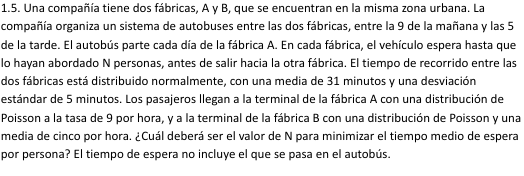

## Código implementación modelo ejercicio 1.5


============ Resultados ============
Simulación de Sistema de Autobus
Fecha de ejecución: Sat May 10 00:34:33 2025

** Parámetros Iniciales **
 - Horario simulado: 480 min (9:00–17:00)
 - Viaje: μ=31 min, σ=5 min
Tiempo medio de llegada de pasajeros (poisson):
 - Terminal A: 9/16 pasajeros/hora
 - Terminal B: 5/16 pasajeros/hora
N óptimizado: 10 pasajeros

** Estadísticas por Terminal **
Terminal A: atendidos=60, rezagados=-3
Terminal B: atendidos=50, rezagados=6

** Métricas de Cola **
 - Área Q_A(t):    2795.16 pasajeros·min
 - Área Q_B(t):    1875.59 pasajeros·min
 - Área Q_tot :    4670.74 pasajeros·min
 - Pers. rezagadas tot.: 3

** Rendimiento del Bus **
 - Viajes realizados: 11
 - Utilización: 68.06 %

** Tiempos de Espera **
 - Espera media A:  38.82 min
 - Espera media B:  46.89 min
 - Espera media total:  42.49 min


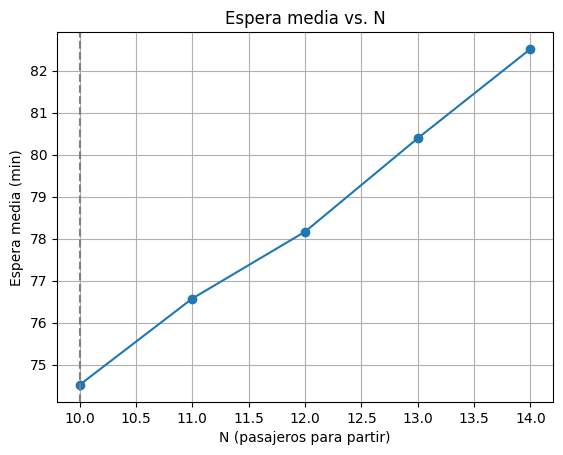

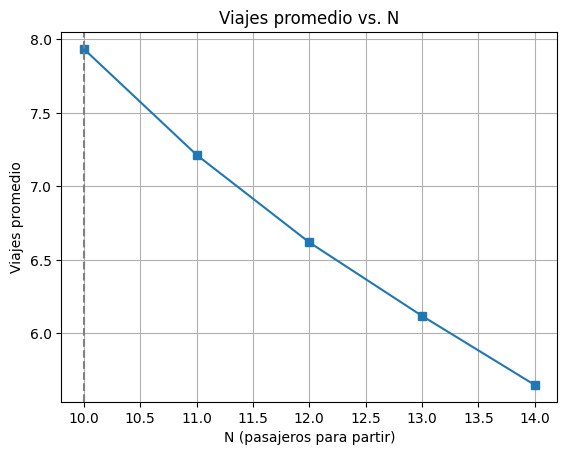

In [ ]:
#Taller 1 Modelos y Simulacion.
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# Parámetros globales
LAMBDA_A    = 9 / 60      # llegadas en A (pasajeros por minuto)
LAMBDA_B    = 5 / 60      # llegadas en B (pasajeros por minuto)
TIMEOP     = 8 * 60      # minutos de operación (9:00–17:00)
MEAN_TRAVEL = 31          # tiempo medio de viaje (minutos)
SD_TRAVEL   = 5           # desviación estándar del viaje

def generate_arrivals(rate: float, TIMEOP: float) -> list[float]:
    """Genera tiempos de llegada hasta `TIMEOP` según distribucion Poisson."""
    arr, t = [], 0.0
    while True:
        t += np.random.exponential(1 / rate)
        if t > TIMEOP:
            break
        arr.append(t)
    return arr

def simulate_one_day(N: int):
    """
    Simula un día y retorna:
      - waits_A, waits_B: listas de tiempos de espera en cola en A y B.
      - served_A, served_B: pasajeros servidos en A y B.
      - rem_A, rem_B: pasajeros que quedaron en cola al cierre.
      - trips: total de viajes realizados.
      - travel_time_accum: suma de todos los tiempos de viaje del bus.
    """
    # llegadas iniciales
    init_A = generate_arrivals(LAMBDA_A, TIMEOP)
    init_B = generate_arrivals(LAMBDA_B, TIMEOP)
    arrA, arrB = list(init_A), list(init_B)

    idxA = idxB = 0
    t = 0.0
    loc = 'A'
    waits_A = []
    waits_B = []
    served_A = served_B = trips = 0
    travel_time_accum = 0.0

    while True:
        if loc == 'A':
            arrivals, idx, rate = arrA, idxA, LAMBDA_A
        else:
            arrivals, idx, rate = arrB, idxB, LAMBDA_B

        # asegurar N pasajeros generados
        while idx + N > len(arrivals):
            last = arrivals[-1] if arrivals else 0.0
            arrivals.append(last + np.random.exponential(1 / rate))

        depart = max(t, arrivals[idx + N - 1])
        if depart > TIMEOP:
            break

        # registrar esperas y servidos
        for i in range(N):
            at = arrivals[idx + i]
            if at <= TIMEOP:
                wait = depart - at
                if loc == 'A':
                    waits_A.append(wait)
                    served_A += 1
                else:
                    waits_B.append(wait)
                    served_B += 1

        # avanzar índices y contar viaje
        if loc == 'A':
            idxA += N
        else:
            idxB += N
        trips += 1

        # simular viaje y al final de cada iteracion aumenta los acumuladores
        travel = -1.0
        while travel <= 0:
            travel = np.random.normal(MEAN_TRAVEL, SD_TRAVEL)   #distribuye normalmente el tiempo de viajes
        travel_time_accum += travel
        t = depart + travel
        loc = 'B' if loc == 'A' else 'A'

    # pasajeros rezagados en cola al cierre
    rem_A = len(init_A) - served_A
    rem_B = len(init_B) - served_B

    return waits_A, waits_B, served_A, served_B, rem_A, rem_B, trips, travel_time_accum  #tiempos de espera, pasajeros atendidos, pasajeros rezagados,viajes y tiempo de viaje total

def evaluate_Ns(Ns, reps=200):
    avg_waits = []
    avg_trips = []
    for N in Ns:
        w_reps = []
        t_reps = []
        for _ in range(reps):
            wa, wb, sA, sB, rA, rB, tr, travel_acc = simulate_one_day(N)
            w_reps.append(np.mean(wa + wb) if (wa+wb) else np.nan)
            t_reps.append(tr)
        avg_waits.append(np.nanmean(w_reps))
        avg_trips.append(np.mean(t_reps))
    return avg_waits, avg_trips

if __name__ == "__main__":
    Ns = list(range(10,15))
    REPS = 10000

    # Optimización de N
    avg_waits, avg_trips = evaluate_Ns(Ns, reps=REPS)
    best_idx = int(np.nanargmin(avg_waits))
    best_N   = Ns[best_idx]

    # Simulación detallada con N óptimo
    wa, wb, sA, sB, rA, rB, trips, travel_acc = simulate_one_day(best_N)
    total_wait = sum(wa) + sum(wb)
    avg_wait_A = np.mean(wa) if wa else 0.0
    avg_wait_B = np.mean(wb) if wb else 0.0
    avg_wait   = total_wait / (sA + sB)
    # Little's Law para área bajo Q(t)
    area_QA    = LAMBDA_A * avg_wait_A * TIMEOP
    area_QB    = LAMBDA_B * avg_wait_B * TIMEOP
    area_Qtot  = area_QA + area_QB
    rem_total  = rA + rB
    utilization= (travel_acc / TIMEOP) * 100

    # Reporte
    print("\n" + "="*12 + " Resultados " + "="*12)
    print("Simulación de Sistema de Autobus")
    print("Fecha de ejecución:", datetime.now().strftime("%c"))
    print("\n** Parámetros Iniciales **")
    print(f" - Horario simulado: {TIMEOP:.0f} min (9:00–17:00)")
    print(f" - Viaje: μ={MEAN_TRAVEL} min, σ={SD_TRAVEL} min")
    print(f"Tiempo medio de llegada de pasajeros (poisson):")
    print(f" - Terminal A: 9/16 pasajeros/hora")
    print(f" - Terminal B: 5/16 pasajeros/hora")
    print(f"N óptimizado: {best_N} pasajeros\n")

    print("** Estadísticas por Terminal **")
    print(f"Terminal A: atendidos={sA}, rezagados={rA}")
    print(f"Terminal B: atendidos={sB}, rezagados={rB}\n")

    print("** Métricas de Cola **")
    print(f" - Área Q_A(t): {area_QA:10.2f} pasajeros·min")
    print(f" - Área Q_B(t): {area_QB:10.2f} pasajeros·min")
    print(f" - Área Q_tot : {area_Qtot:10.2f} pasajeros·min")
    print(f" - Pers. rezagadas tot.: {rem_total}\n")

    print("** Rendimiento del Bus **")
    print(f" - Viajes realizados: {trips}")
    print(f" - Utilización: {utilization:.2f} %\n")

    print("** Tiempos de Espera **")
    print(f" - Espera media A: {avg_wait_A:6.2f} min")
    print(f" - Espera media B: {avg_wait_B:6.2f} min")
    print(f" - Espera media total: {avg_wait:6.2f} min")
    print("="*50)

    # Gráficas
    plt.figure()
    plt.plot(Ns, avg_waits, marker='o')
    plt.axvline(best_N, linestyle='--', color='gray')
    plt.title("Espera media vs. N")
    plt.xlabel("N (pasajeros para partir)")
    plt.ylabel("Espera media (min)")
    plt.grid(True)
    plt.show()

    plt.figure()
    plt.plot(Ns, avg_trips, marker='s')
    plt.axvline(best_N, linestyle='--', color='gray')
    plt.title("Viajes promedio vs. N")
    plt.xlabel("N (pasajeros para partir)")
    plt.ylabel("Viajes promedio")
    plt.grid(True)
    plt.show()

##Codigo implementación modelo ejercicio 1.6##

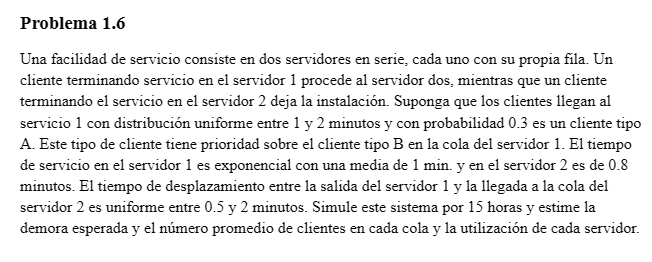

# **Problema 1.6**

Instalacion de librerias

In [2]:
pip install simpy

## Importaciones necesarias

In [3]:
import simpy
import random

## Simulacion

In [6]:
# Variables de estado y metricas
Q1 = Q2 = 0               # Longitudes de cola
S1_busy = False           # Indicador de ocupacion como booleano
S2_busy = False           # Indicador de ocupacion como booleano
area_Q1 = area_Q2 = 0.0   # Integrales de número en cola
t_busy_S1 = t_busy_S2 = 0.0  # Tiempo ocupado por servidores
sum_delay_S1 = sum_delay_S2 = 0.0  # Suma de demoras en cola
n_completed_S1 = n_completed_S2 = 0  # Conteo de clientes servidos
last_event_time = 0.0     # Tiempo del ultimo evento

T = 15 * 60               #Tiempo total de simulacion

# Función para actualizar métricas
def update_stats(env):
    global area_Q1, area_Q2, t_busy_S1, t_busy_S2, last_event_time
    global Q1, Q2, S1_busy, S2_busy
    dt = env.now - last_event_time
    area_Q1 += Q1 * dt
    area_Q2 += Q2 * dt

    t_busy_S1 += (1 if S1_busy else 0) * dt
    t_busy_S2 += (1 if S2_busy else 0) * dt
    last_event_time = env.now

# Definición del proceso de cada cliente
def customer(env, cid):
    global Q1, Q2, S1_busy, S2_busy
    global sum_delay_S1, sum_delay_S2, n_completed_S1, n_completed_S2

    arrival_time_s1 = env.now
    tipo = 'A' if random.random() < 0.3 else 'B'
    priority = 0 if tipo == 'A' else 1


    update_stats(env)
    Q1 += 1

    # Servicio en servidor 1 con prioridad
    with server1.request(priority=priority) as req1:
        yield req1
        update_stats(env)
        Q1 -= 1
        S1_busy = True
        delay1 = env.now - arrival_time_s1
        sum_delay_S1 += delay1
        n_completed_S1 += 1
        yield env.timeout(random.expovariate(1/1.0))  # media 1 min
        update_stats(env)
        S1_busy = False

    # Desplazamiento al servidor 2
    yield env.timeout(random.uniform(0.5, 2.0))

    # Llegada a cola 2
    update_stats(env)
    Q2 += 1
    arrival_time_s2 = env.now

    # Servicio en servidor 2
    with server2.request() as req2:
        yield req2
        update_stats(env)
        Q2 -= 1
        S2_busy = True
        delay2 = env.now - arrival_time_s2
        sum_delay_S2 += delay2
        n_completed_S2 += 1
        yield env.timeout(random.expovariate(1/0.8))  # media 0.8 min
        update_stats(env)
        S2_busy = False

# Generador de llegadas
def arrival_process(env):
    cid = 0
    while True:
        interarrival = random.uniform(1, 2)
        yield env.timeout(interarrival)
        if env.now > T:
            break
        cid += 1
        env.process(customer(env, cid))

# Configuración del entorno
env = simpy.Environment()
server1 = simpy.PriorityResource(env, capacity=1)
server2 = simpy.Resource(env, capacity=1)

# Iniciar llegada de clientes
env.process(arrival_process(env))

# Ejecutar simulación
env.run(until=T)
# Actualizar métricas hasta el final
update_stats(env)

# Cálculo de medidas de desempeño
delay1_avg = sum_delay_S1 / n_completed_S1
delay2_avg = sum_delay_S2 / n_completed_S2
L1 = area_Q1 / T
L2 = area_Q2 / T
rho1 = t_busy_S1 / T
rho2 = t_busy_S2 / T

# Mostrar resultados
print(f"Demora media en cola Servidor 1: {delay1_avg:.3f} min")
print(f"Demora media en cola Servidor 2: {delay2_avg:.3f} min")
print(f"Número promedio en cola Servidor 1: {L1:.3f}")
print(f"Número promedio en cola Servidor 2: {L2:.3f}")
print(f"Utilización Servidor 1: {rho1:.3f}")
print(f"Utilización Servidor 2: {rho2:.3f}")

Demora media en cola Servidor 1: 0.644 min
Demora media en cola Servidor 2: 0.542 min
Número promedio en cola Servidor 1: 0.435
Número promedio en cola Servidor 2: 0.362
Utilización Servidor 1: 0.643
Utilización Servidor 2: 0.522
